# Imports

In [1]:
# basic dependencies

# basic dependencies


import numpy as np
from numpy import loadtxt
from numpy import savetxt
import os

import pandas as pd
import math
import time
from datetime import datetime, date
import scipy
from scipy import signal
from scipy.optimize import curve_fit

import re
np.set_printoptions(formatter={'float': lambda x: "{0:0.3f}".format(x)})

###########

# torch dependencies
import torch

tkwargs = {"dtype": torch.double, # set as double to minimize zero error for cholesky decomposition error
           "device": torch.device("cuda:0" if torch.cuda.is_available() else "cpu")} # set tensors to GPU, if multiple GPUs please set cuda:x properly

torch.set_printoptions(precision=3)

###########

# botorch dependencies
import botorch

# data related
from botorch.utils.sampling import draw_sobol_samples
from botorch.utils.transforms import unnormalize, normalize

# surrogate model specific
from botorch.models.gp_regression import SingleTaskGP
from botorch.models.model_list_gp_regression import ModelListGP
from botorch.models.transforms.outcome import Standardize
from gpytorch.mlls.sum_marginal_log_likelihood import SumMarginalLogLikelihood
from botorch import fit_gpytorch_model

# qNEHVI specific
from botorch.acquisition.multi_objective.objective import IdentityMCMultiOutputObjective
from botorch.acquisition.multi_objective.monte_carlo import qNoisyExpectedHypervolumeImprovement

# utilities
from botorch.optim.optimize import optimize_acqf
from botorch.sampling import SobolQMCNormalSampler
from botorch.utils.multi_objective.pareto import is_non_dominated
from botorch.utils.multi_objective.hypervolume import Hypervolume
from typing import Optional
from torch import Tensor
from botorch.exceptions import BadInitialCandidatesWarning

from gpytorch.constraints import GreaterThan
from torch.optim import SGD
from gpytorch.mlls import ExactMarginalLogLikelihood

import warnings

warnings.filterwarnings('ignore', category=BadInitialCandidatesWarning)
warnings.filterwarnings('ignore', category=RuntimeWarning)

# plotting dependencies
import matplotlib
from matplotlib import pyplot as plt
%matplotlib inline

SMALL_SIZE = 14
MEDIUM_SIZE = 18
BIGGER_SIZE = 20

plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

# Class definitiosns

In [2]:
class BO_LiqTransfer:

    def __init__(self, liquid_name, density):
        self.liquid_name = liquid_name
        self.density = density
        self._data = pd.DataFrame(columns = ['liquid', 'pipette', 'volume', 'aspiration_rate', 'dispense_rate', 'delay_aspirate', 'delay_dispense','iteration','liquid_level','density', 'time', 'm', '%error','time_asp_1000','acq_value'])
        self.features = ['aspiration_rate','dispense_rate']
        self.objectives = ['%error','time_asp_1000']
        self.bmax = 1.25
        self.bmin = 0.1
        self._first_approximation = None
        self._latest_suggestion = None
        self._latest_volume = None
        self._latest_acq_value = None
        self.mean_volumes = [1000,500,300]
        self.platform = None
    
   
    def cleanTip(self,source_well, repetitions =1 ):
        
        self.platform.mover.safeMoveTo(source_well.top)
        
        for i in range(repetitions):
            self.platform.liquid.blowout(home=False) 
            time.sleep(5)
            self.platform.liquid.home()
            self.platform.setup.touchTip(source_well)
            time.sleep(5)

            self.platform.liquid.blowout(home=False) 
            time.sleep(5)
            self.platform.liquid.home()
            self.platform.setup.touchTip(source_well)
            time.sleep(5)

            self.platform.liquid.blowout(home=False) 
            time.sleep(5)
            self.platform.liquid.home()
            self.platform.setup.touchTip(source_well)
            time.sleep(5)

    
    def gravimetric_transfer(self, volume, liquid_level, source_well,balance_well, aspiration_rate, dispense_rate):
        #liquid transfer
        #transfer start
        start = time.time() 

        #aspirate step
        self.platform.mover.safeMoveTo(source_well.from_bottom((0,0,liquid_level-5))) 
        self.platform.liquid.aspirate(volume, speed=aspiration_rate)
        time.sleep(10)

        self.platform.setup.touchTip(source_well) 

        #dispense step
        self.platform.mover.safeMoveTo(balance_well.from_top((0,0,-5))) 
        self.platform.balance.tare() 
        self.platform.balance.clearCache() 
        self.platform.balance.toggleRecord(True) 
        time.sleep(5)
        self.platform.liquid.dispense(volume,speed=dispense_rate)
        time.sleep(10)

        #transfer termination
        finish = time.time() 
        time_m = finish - start

        self.platform.mover.safeMoveTo(source_well.top) 
        time.sleep(5)
        self.platform.balance.toggleRecord(False) 

        #do blowout
        
        self.cleanTip(source_well)

        #record transfer values 
        #calculating mass error functions
        m = (self.platform.balance.buffer_df.iloc[-10:,-1].mean()-self.platform.balance.buffer_df.iloc[:10,-1].mean())/1000 
        error = (m-self.density*volume/1000)/(self.density/1000*volume)*100
        
        #change liquid levels
        liquid_level = liquid_level - 2*m/self.density   
        
        #making new dataframe + filling it in
        df = pd.DataFrame(columns=self._data.columns)            
        
        df = pd.concat([df,pd.DataFrame({
            "liquid": self.liquid_name,
            'pipette': 'rLine1000',
            "volume": volume,
            "aspiration_rate": aspiration_rate,
            "dispense_rate": dispense_rate, 
            "delay_aspirate" : 10,  
            "delay_dispense" : 10,
            'iteration': 'NaN',
            "liquid_level" : liquid_level,
            "density" : self.density,
            "time" : time_m,
            "m": m,
            "%error": error,
            "time_asp_1000" : 'NaN',
            "acq_value": self._latest_acq_value
            },index=[0])],ignore_index=True)
        
        return liquid_level, df

    def obtainAproximateRate(self, initial_liquid_level_balance,balance_well,speed=265, file_name=None):

        liquid_level = initial_liquid_level_balance
        
        if self.platform.liquid.isTipOn()== False:
            self.platform.setup.attachTip()
        
        self.platform.mover.safeMoveTo(balance_well.from_bottom((0,0,liquid_level-5)),descent_speed_fraction=0.25)
        #Starting balance measurement
        time.sleep(5)
        self.platform.balance.zero(wait=5)
        self.platform.balance.clearCache()
        self.platform.balance.toggleRecord(on=True)
        time.sleep(15)

        self.platform.liquid.aspirate(1000, speed=speed)

        #Switching the balance off after change in mass is less than 0.05
        while True:
            data = self.platform.balance.buffer_df
            data['Mass_smooth']= signal.savgol_filter(data['Mass'],91,1)
            data['Mass_derivative_smooth']=data['Mass_smooth'].diff()
            condition=data['Mass_derivative_smooth'].rolling(30).mean().iloc[-1]
            if condition>-0.05:
                time.sleep(5)
                break
        print('loop stopped')
        self.platform.balance.toggleRecord(on=False)

        self.platform.mover.moveTo(balance_well.from_top((0,0,-5)))

        def sigmoid(x, L ,x0, k,p,b):
            y = L / (1 + np.exp(k*(x-x0)))**(1/p) + b
            return y


        #using data from balance buffer_df above, calculate time in seconds and mass derivatives
        data['ts'] = data['Time'].astype('datetime64[ns]').values.astype('float') / 10 ** 9
        data['ts']= data['ts']-data['ts'][0]
        data_fit = data.where(data['ts']>10).dropna()
        data_fit['Mass']=data_fit['Mass']-data_fit['Mass'].iloc[0]
        data_fit['Mass_smooth'] = data_fit['Mass_smooth']-data_fit['Mass_smooth'].iloc[0]

        p0 = [min(data_fit['Mass']), np.median(data_fit['ts']),1,1,max(data_fit['Mass'])+30]
        
        popt, pcov = curve_fit(sigmoid, data_fit['ts'], data_fit['Mass'],p0)

        mass_sigmoid = sigmoid(data_fit['ts'],popt[0],popt[1],popt[2],popt[3],popt[4])

        data_fit.loc[data_fit.index[0]:,'Mass_sigmoid'] = mass_sigmoid

        flow_rate = -data_fit['Mass_sigmoid'].dropna().diff()/data_fit.loc[data_fit['Mass_sigmoid'].dropna().index,'ts'].diff()
        initial_flow_rate_aspirate = round(flow_rate.max()*(1/self.bmax),2)
        
        self._first_approximation = initial_flow_rate_aspirate 
        
        #switching balance off and saving csv
        if file_name != None:
            data_fit.to_csv(file_name, index=False)

        self.platform.liquid.dispense(1000,speed= self._first_approximation)


    def exploreBoundaries(self, initial_liquid_level_source,source_well,balance_well):
        self.platform.mover.setSpeed(50)
        self.platform.mover.setHandedness(False)

        if type(self._data) == None:
            df = pd.DataFrame(columns = ['liquid', 'pipette', 'volume', 'aspiration_rate', 'dispense_rate', 'delay_aspirate', 'delay_dispense','iteration','liquid_level','density', 'time', 'm', '%error','time_asp_1000','acq_value'])
            df = df.astype({'liquid':str,'pipette':str})
            self.set_data(df)
        
        liquid_level = initial_liquid_level_source

        #Check if new tip is required
        if self.platform.liquid.isTipOn()== False:
            self.platform.setup.attachTip()

        volumes_list = self.mean_volumes
        
        #NOT TO BE CHANGED
        counter = 1
        iterations = 5
        #while loop
        while counter <= iterations:
            #hardcoding aspirate and dispense rates:
            if counter == 1:
                aspiration_rate = self._first_approximation
                dispense_rate = self._first_approximation
            if counter == 2:
                aspiration_rate = self._first_approximation*self.bmax
                dispense_rate = self._first_approximation*self.bmax
            if counter == 3:
                aspiration_rate = self._first_approximation*self.bmax
                dispense_rate = self._first_approximation*self.bmin
            if counter == 4:
                aspiration_rate = self._first_approximation*self.bmin
                dispense_rate = self._first_approximation*self.bmax
            if counter == 5:
                aspiration_rate = self._first_approximation*self.bmin
                dispense_rate = self._first_approximation*self.bmin


            #for loop
            for volume in volumes_list:
                #liquid transfer
                liquid_level,df = self.gravimetric_transfer(volume,liquid_level,source_well,balance_well,aspiration_rate,dispense_rate)
                
                m=df.m.iloc[-1]

                self.set_data(pd.concat([self._data,df]).reset_index(drop=True))
                #printing checks
                print("LIQUID LEVEL: " +str(liquid_level) + "   LIQUID CHANGE: " +str(1.2*m/self.density) + "   ITERATION: " + str(counter) + ", " + "VOLUME: " + str(volume))    

                #liquid level checks
                if (1.2*m/self.density > 1.2) or (1.2*m/self.density < 0):
                    break
                if (liquid_level > initial_liquid_level_source) or (liquid_level < 6):
                    break
            #liquid level checks
            if (1.2*m/self.density > 1.2) or (1.2*m/self.density < 0):
                break
            if (liquid_level > initial_liquid_level_source) or (liquid_level < 6): 
                break
            
            counter += 1


    def optimize_parameters(self, initial_liquid_level_source,source_well,balance_well,iterations=5):
        self.platform.mover.setSpeed(50)
        self.platform.mover.setHandedness(False)

        liquid_level = initial_liquid_level_source

        #Check if new tip is required
        if self.platform.liquid.isTipOn()== False:
            self.platform.setup.attachTip()

        volumes_list = self.mean_volumes
        
        #NOT TO BE CHANGED
        counter = 1
       
        #while loop
        while counter <= iterations:
            #getting botorch suggestions + implementing it in liquids_dict
            self.optimized_suggestions()
            aspiration_rate = self._latest_suggestion['aspiration_rate']
            dispense_rate = self._latest_suggestion['dispense_rate']
            #for loop
            for volume in volumes_list:
                #liquid transfer
                liquid_level,df = self.gravimetric_transfer(volume,liquid_level,source_well,balance_well,aspiration_rate,dispense_rate)
                
                m=df.m.iloc[-1]

                self.set_data(pd.concat([self._data,df]).reset_index(drop=True))
                #printing checks
                print("LIQUID LEVEL: " +str(liquid_level) + "   LIQUID CHANGE: " +str(1.2*m/self.density) + "   ITERATION: " + str(counter) + ", " + "VOLUME: " + str(volume))    

                #liquid level checks
                if (1.2*m/self.density > 1.2) or (1.2*m/self.density < 0):
                    break
                if (liquid_level > initial_liquid_level_source) or (liquid_level < 6):
                    break

                
                #printing checks
                print("LIQUID LEVEL: " +str(liquid_level) + "   LIQUID CHANGE: " +str(1.2*m/self.density) + "   ITERATION: " + str(counter) + ", " + "VOLUME: " + str(volume))    

                #liquid level checks
                if (1.2*m/self.density > 1.2) or (1.2*m/self.density < 0):
                    break
                if (liquid_level > initial_liquid_level_source) or (liquid_level < 6):
                    break
            #liquid level checks
            if (1.2*m/self.density > 1.2) or (1.2*m/self.density < 0):
                break
            if (liquid_level > initial_liquid_level_source) or (liquid_level < 6): 
                break
            
            counter += 1


    def verify_parameters(self, initial_liquid_level_source,source_well,balance_well,iterations=10, file_name=None):
        self.platform.mover.setSpeed(50)
        self.platform.mover.setHandedness(False)

        liquid_level = initial_liquid_level_source

        # Check if new tip is required
        if self.platform.liquid.isTipOn()== False:
            self.platform.setup.attachTip()

        volumes_list = self.mean_volumes
        
        #NOT TO BE CHANGED
     
        
        mean_average_data = self._data.where(self._data.volume == 'mean'+str(self.mean_volumes))
        mean_average_data = mean_average_data.where(mean_average_data.iteration>5).dropna()
        best_parameter_index = mean_average_data[mean_average_data['%error']==mean_average_data['%error'].max()].index

        aspiration_rate = self._data.loc[best_parameter_index,'aspiration_rate'].values[0]
        dispense_rate = self._data.loc[best_parameter_index,'dispense_rate'].values[0]
        
        verify_df = pd.DataFrame(columns = ['liquid', 'pipette', 'volume', 'aspiration_rate', 'dispense_rate', 'delay_aspirate', 'delay_dispense','liquid_level','density', 'm', '%error'])
        
        #for loop
            
        for volume in volumes_list:
            counter = 1
            # #while loop
            while counter <= iterations:
             
                #liquid transfer
                liquid_level,df = self.gravimetric_transfer(volume,liquid_level,source_well,balance_well,aspiration_rate,dispense_rate)
                
                verify_df = pd.concat([verify_df,df[verify_df.columns]]).reset_index(drop=True)

                m=df.m.iloc[-1]

                #printing checks
                print("Mass: "+str(m)+"LIQUID LEVEL: " +str(liquid_level) + "   LIQUID CHANGE: " +str(1.2*m/self.density) + "   ITERATION: " + str(counter) + ", " + "VOLUME: " + str(volume))    

                #liquid level checks
                if (1.2*m/self.density > 1.2) or (1.2*m/self.density < 0):
                    break
                if (liquid_level > initial_liquid_level_source) or (liquid_level < 6):
                    break

                counter += 1
            #liquid level checks
            if (1.2*m/self.density > 1.2) or (1.2*m/self.density < 0):
                break
            if (liquid_level > initial_liquid_level_source) or (liquid_level < 6): 
                break
            
        if file_name != None:
            verify_df.to_csv(file_name, index=False)
        return verify_df



    def set_data(self,df):
        iteration = 1
        nan_columns = df.columns.to_list()
        nan_columns = [e for e in nan_columns if e not in ('liquid',
        'pipette',
        'volume',
        'aspiration_rate',
        'dispense_rate',
        'blow_out_rate',
        'delay_aspirate',
        'delay_dispense',
        'delay_blow_out',
        'touch_tip_aspirate',
        'touch_tip_dispense',
        'density',
        '%error',
        'time_asp_1000',
        'acq_value',
        'iteration',
        'liquid_level')]

        df['time_asp_1000'] = 1000/df['aspiration_rate'] + 1000/df['dispense_rate'] + df['delay_aspirate'] + df['delay_dispense']

        if 'acq_value' not in df.columns:
            df['acq_value'] = None

        if df.loc[:,self.features].duplicated().sum()==0:
            df_mean = df
        else:
            df_duplicates = df.where(df.duplicated(self.features,keep=False)==True).dropna(how='all')
            df_incomplete = df.where(df.duplicated(self.features,keep=False)==False).dropna(how='all')
            df_mean = pd.DataFrame(columns= df.columns)
            for index,values in df_duplicates.drop_duplicates(self.features).iterrows():
                if len(df_duplicates.loc[index:index+2]) == len(self.mean_volumes):
                    mean_error =df_duplicates.loc[index:index+2,'%error'].abs().mean()
                    df_duplicates.loc[index,'%error'] = -mean_error
                    df_duplicates.loc[index, 'volume'] ='mean'+str(self.mean_volumes)
                    df_duplicates.loc[index, 'iteration']= iteration
                    df_duplicates.loc[index, 'liquid_level']= df.loc[index+2,'liquid_level']
                    df.loc[index:index+2, 'iteration'] = iteration
                    df_duplicates.loc[index, nan_columns]= 'NaN'
                    df_mean = pd.concat([df_mean,df.loc[index:index+2],df_duplicates.loc[[index]]])
                    iteration +=1 
                else:
                    df_incomplete = pd.concat([df_incomplete,df_duplicates.loc[index:index+2]]).drop_duplicates()
            df_mean = pd.concat([df_mean,df_incomplete])
            df_mean = df_mean.reset_index(drop=True)    
        self._data = df_mean
 
        



    def data_from_csv(self,file_name):
        data = pd.read_csv(file_name)
        self.set_data(data)



    def update_data(self,df):
        self._latest_volume = df['volume'].iloc[-1]
        updated_data = pd.concat([self._data,df],ignore_index=True)
        self.set_data(updated_data)
        return self._data
                                

    def xy_split(self):
        df_train = self._data.where(self._data['volume']=='mean'+str(self.mean_volumes)).dropna(how='all')
        x_train = df_train[self.features]
        y_train = df_train[self.objectives]
        return x_train,y_train

    def set_bounds(self, x_train):
        return torch.vstack([x_train[0]*self.bmin, x_train[0]*self.bmax])



    def fit_surrogate(self):
        x_train, y_train = self.xy_split()
        x_train = torch.tensor(x_train.to_numpy(dtype=float), **tkwargs)
        y_train = torch.tensor(y_train.to_numpy(dtype=float), **tkwargs)
        y_train[:,0] = -torch.absolute(y_train[:,0])
        y_train[:,1] = -torch.absolute(y_train[:,1])

        problem_bounds = self.set_bounds(x_train)
        time_upper = 1000/problem_bounds[0][0] +1000/problem_bounds[0][1] + 10
        error_upper = y_train[:,0].abs().min()*1.25
        ref_point = torch.tensor([-error_upper,-time_upper], **tkwargs)

        train_x_gp = normalize(x_train, problem_bounds)
        models = []
        for i in range(y_train.shape[-1]):
            models.append(SingleTaskGP(train_x_gp, y_train[..., i : i + 1], outcome_transform=Standardize(m=1)))
        model1 = ModelListGP(*models)
        mll1 = SumMarginalLogLikelihood(model1.likelihood, model1)

        fit_gpytorch_model(mll1)
    
        return model1, ref_point, train_x_gp, problem_bounds
    
    def optimized_suggestions(self, random_state= 42):
        if random_state != None:
            torch.manual_seed(random_state) 
        standard_bounds = torch.zeros(2, len(self.features), **tkwargs)
        standard_bounds[1] = 1
        model1, ref_point, train_x_gp, problem_bounds = self.fit_surrogate()
        acq_func1 = qNoisyExpectedHypervolumeImprovement(
        model=model1,
        ref_point=ref_point, # for computing HV, must flip for BoTorch
        X_baseline=train_x_gp, # feed total list of train_x for this current iteration
        sampler=SobolQMCNormalSampler(sample_shape=512),  # determines how candidates are randomly proposed before selection
        objective=IdentityMCMultiOutputObjective(outcomes=np.arange(len(self.objectives)).tolist()), # optimize first n_obj col 
        prune_baseline=True, cache_pending=True)  # options for improving qNEHVI, keep these on
        sobol1 = draw_sobol_samples(bounds=standard_bounds,n=512, q=1).squeeze(1)
        sobol2 = draw_sobol_samples(bounds=standard_bounds,n=512, q=1).squeeze(1)
        sobol_all = torch.vstack([sobol1, sobol2])
            
        acq_value_list = []
        for i in range(0, sobol_all.shape[0]):
            with torch.no_grad():
                acq_value = acq_func1(sobol_all[i].unsqueeze(dim=0))
                acq_value_list.append(acq_value.item())
                
        # filter the best 12 QMC candidates first
        sorted_x = sobol_all.cpu().numpy()[np.argsort((acq_value_list))]
        qnehvi_x = torch.tensor(sorted_x[-12:], **tkwargs)  
        # unormalize our training inputs back to original problem bounds
        new_x =  unnormalize(qnehvi_x, bounds=problem_bounds)
        new_x = pd.DataFrame(new_x.numpy(),columns=['aspiration_rate','dispense_rate'])
        new_x['acq_value'] = sorted(acq_value_list, reverse=True)[:12]
        self._latest_suggestion = new_x[['aspiration_rate','dispense_rate']].iloc[0]
        self._latest_acq_value = new_x['acq_value'].iloc[0]
        return new_x






# Platform initialization

In [3]:
#Import robot related packages and run setup
import pandas as pd
import time
from matplotlib import pyplot as plt
from pathlib import Path
import sys
REPOS = 'GitHub'
ROOT = str(Path().absolute()).split(REPOS)[0]
sys.path.append(f'{ROOT}{REPOS}')

from polylectric.configs.SynthesisB1 import SETUP, LAYOUT_FILE

from controllably import load_deck      # optional
load_deck(SETUP.setup, LAYOUT_FILE)     # optional

platform = SETUP
platform.mover.verbose = False #askpablo

Import: OK <controllably.misc.decorators>
Import: OK <controllably.misc.helper>
Import: OK <controllably.misc.factory>
Import: OK <controllably.misc.layout>
Import: OK <controllably.misc.logger>
Import: OK <controllably.misc.misc_utils>


Import: OK <controllably.Compound.compound_utils>
Import: OK <controllably.Compound.LiquidMover.liquidmover_utils>


Import: OK <controllably.Move.move_utils>
Import: OK <controllably.Move.Jointed.jointed_utils>
Import: OK <controllably.Move.Jointed.Dobot.dobot_utils>
Import: OK <controllably.Move.Jointed.Dobot.m1pro_utils>
Import: OK <controllably.Move.Jointed.Dobot.mg400_utils>
ClearError()
receive: ClearError()
EnableRobot()
receive: EnableRobot()
User(0)
receive: User(0)
Tool(0)
receive: Tool(0)
SetArmOrientation(1,1,1,1)
receive: SetArmOrientation(1,1,1,1)
Infeasible coordinates! (0.0, 0.0, 200.0)
Infeasible coordinates! (300.0, 1.1368683772161603e-13, 0.0)
MovJ(300.000000,0.000000,200.000000,10.000000,0.000000,0.000000)
Move time: 3.000s (1.000x

In [4]:
#Initialization of variables for platform objects
pipette= platform.setup
deck = platform.setup.deck
balance = platform.balance
balance_deck = deck.slots['1']
source = deck.slots['2']
tip_rack = deck.slots['3']
bin = deck.slots['4']
pipette.mover.setSpeed(50)
print(balance_deck)
print(source)
print(tip_rack)
print(bin)

#Check if balance is connected
balance.zero() #to tare
balance.toggleRecord(True) # turn on and record weight
time.sleep(5) # do previous action for 5s
print(balance.buffer_df.iloc[-1]) #iloc can take -1, loc needs to be 839 loc[839,["Time","Value","Factor","Baseline","Mass"]]. -1 is last line. to find number of last line, print(balance.buffer_df)
balance.toggleRecord(False) #turn off

SpeedFactor(50)
receive: SpeedFactor(50)
AMDM 1 Well Mass Balance 40000 μL at Slot 1
AMDM 8 Well Plate 30000 µL at Slot 2
Eppendorf Motion 96 Tip Rack 1000 µL at Slot 3
Polyetric_bin at Slot 4
Listening...
Zeroing... (5s)
Stop listening...
Zeroing complete.
Listening...
Time        2023-09-12 09:27:43.368369
Value                           388091
Factor                        6.862879
Baseline                 388037.907407
Mass                          7.736198
Name: 24, dtype: object
Stop listening...


# Sample definition

In [5]:
liq = BO_LiqTransfer('Viscosity_std_204',0.8639)
liq.platform = platform


In [6]:
liq.obtainAproximateRate(9,balance_deck.wells['A1'],file_name='Viscosity_std_204_flow_rate_inverse.csv')

liq.cleanTip(source.wells['A1'])

liq.exploreBoundaries(49.5,source.wells['A1'],balance_deck.wells['A1'])

source_iquid_level = liq._data['liquid_level'].iloc[-1]

liq.optimize_parameters(initial_liquid_level_source=source_iquid_level,source_well=source.wells['A1'],balance_well=balance_deck.wells['A1'])


Tip capacitance: 248
Tip capacitance: 249
A1
Tip capacitance: 249
SpeedFactor(20)
receive: SpeedFactor(20)
MovJ(300.000000,0.000000,200.000000,10.000000,0.000000,0.000000)
Move time: 0.000s (0.200x)
[300.000 0.000 200.000], [10  0  0]
SpeedFactor(50)
receive: SpeedFactor(50)
MovJ(198.894071,-3.942538,200.000000,10.000000,0.000000,0.000000)
Move time: 2.022s (0.500x)
[198.894 -3.943 200.000], [10  0  0]
SpeedFactor(20)
receive: SpeedFactor(20)
MovJ(198.894071,-3.942538,65.400000,10.000000,0.000000,0.000000)
Move time: 6.730s (0.200x)
[198.894 -3.943 65.400], [10  0  0]
SpeedFactor(50)
receive: SpeedFactor(50)
SpeedFactor(1)
receive: SpeedFactor(1)
MovJ(198.894071,-3.942538,45.400000,10.000000,0.000000,0.000000)
Move time: 20.000s (0.010x)
[198.894 -3.943 45.400], [10  0  0]
SpeedFactor(50)
receive: SpeedFactor(50)
SpeedFactor(20)
receive: SpeedFactor(20)
MovJ(198.894071,-3.942538,162.300000,10.000000,0.000000,0.000000)
Move time: 5.845s (0.200x)
[198.894 -3.943 162.300], [10  0  0]
Spee

C:\Users\amdm_\AppData\Local\Temp\ipykernel_20412\2894666950.py:390: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  df.loc[index:index+2, 'iteration'] = iteration


LIQUID LEVEL: 46.316916111579495   LIQUID CHANGE: 0.3195497780651734   ITERATION: 1, VOLUME: 300
SpeedFactor(100)
receive: SpeedFactor(100)
MovJ(200.735825,-153.588756,200.000000,10.000000,0.000000,0.000000)
Move time: 0.816s (1.000x)
[200.736 -153.589 200.000], [10  0  0]
SpeedFactor(50)
receive: SpeedFactor(50)
MovJ(200.735825,-153.588756,200.000000,10.000000,0.000000,0.000000)
Move time: 0.000s (0.500x)
[200.736 -153.589 200.000], [10  0  0]
SpeedFactor(100)
receive: SpeedFactor(100)
MovJ(200.735825,-153.588756,89.216916,10.000000,0.000000,0.000000)
Move time: 1.108s (1.000x)
[200.736 -153.589 89.217], [10  0  0]
SpeedFactor(50)
receive: SpeedFactor(50)
Aspirating 1000.0 uL...
Target: 1000.0 uL at 215.0 uL/s...
Best parameters: SpeedParameters(preset=650, intervals=3, step_size=133, delay=1.037567084078712)
SpeedParameters(preset=650, intervals=3, step_size=133, delay=1.037567084078712)
Speed 4: 650 uL/s
Aspiration time: 4.653407599951606s
SpeedFactor(20)
receive: SpeedFactor(20)
Mo

In [ ]:
liq.optimize_parameters(initial_liquid_level_source=34,source_well=source.wells['A1'],balance_well=balance_deck.wells['A1'])


In [93]:
df = liq.verify_parameters(46.5,source_well=source.wells['A1'],balance_well=balance_deck.wells['A1'],file_name='full_auto_204_verify_inverse.csv')

Tip capacitance: 249
SpeedFactor(100)
receive: SpeedFactor(100)
MovJ(200.735825,-153.588756,200.000000,10.000000,0.000000,0.000000)
Move time: 0.616s (1.000x)
[200.736 -153.589 200.000], [10  0  0]
SpeedFactor(50)
receive: SpeedFactor(50)
MovJ(200.735825,-153.588756,200.000000,10.000000,0.000000,0.000000)
Move time: 0.000s (0.500x)
[200.736 -153.589 200.000], [10  0  0]
SpeedFactor(100)
receive: SpeedFactor(100)
MovJ(200.735825,-153.588756,89.400000,10.000000,0.000000,0.000000)
Move time: 1.106s (1.000x)
[200.736 -153.589 89.400], [10  0  0]
SpeedFactor(50)
receive: SpeedFactor(50)
Aspirating 1000.0 uL...
Target: 1000.0 uL at 83.47337041012943 uL/s...
Best parameters: SpeedParameters(preset=650, intervals=10, step_size=40, delay=1.0441406952372163)
SpeedParameters(preset=650, intervals=10, step_size=40, delay=1.0441406952372163)
Speed 4: 650 uL/s
Aspiration time: 11.986051300016697s
SpeedFactor(20)
receive: SpeedFactor(20)
MovJ(200.735825,-153.588756,108.400000,10.000000,0.000000,0.000

In [95]:
platform.setup.ejectTip()

Tip capacitance: 249
Tip capacitance: 249
SetArmOrientation(1,1,1,1)
receive: SetArmOrientation(1,1,1,1)
MovJ(320.000000,-240.000000,118.400000,10.000000,0.000000,0.000000)
Move time: 2.385s (0.500x)
[320.000 -240.000 118.400], [10  0  0]
SpeedFactor(20)
receive: SpeedFactor(20)
MovJ(320.000000,-240.000000,200.000000,10.000000,0.000000,0.000000)
Move time: 4.080s (0.200x)
[320.000 -240.000 200.000], [10  0  0]
SpeedFactor(50)
receive: SpeedFactor(50)
MovJ(232.616399,194.960923,200.000000,10.000000,0.000000,0.000000)
Move time: 8.699s (0.500x)
[232.616 194.961 200.000], [10  0  0]
SpeedFactor(20)
receive: SpeedFactor(20)
MovJ(232.616399,194.960923,114.400000,10.000000,0.000000,0.000000)
Move time: 4.280s (0.200x)
[232.616 194.961 114.400], [10  0  0]
SpeedFactor(50)
receive: SpeedFactor(50)


array([524.500, 50.000, 70.000])

Listening...
Zeroing... (5s)
Stop listening...
Zeroing complete.
Listening...
Stop listening...


<Axes: xlabel='Time'>

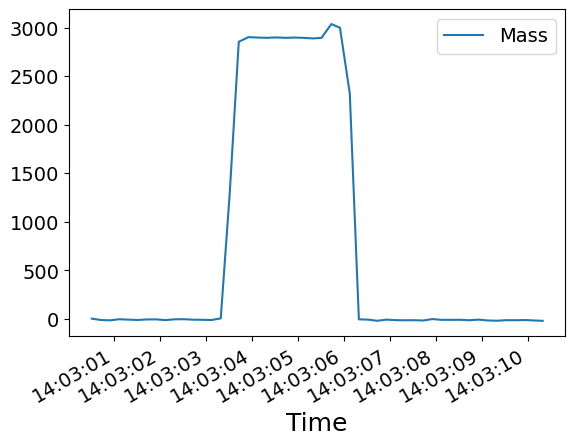

In [92]:
balance.clearCache()
balance.zero()
balance.toggleRecord(True)
time.sleep(10)
balance.toggleRecord(False)
balance.buffer_df.plot('Time','Mass')

,liquid,pipette,volume,aspiration_rate,dispense_rate,delay_aspirate,delay_dispense,liquid_level,density,m,%error
0,Viscosity_std_204,rLine1000,1000,83.47337,26.404968,10,10,44.579659,0.8639,0.829491,-3.982929
1,Viscosity_std_204,rLine1000,1000,83.47337,26.404968,10,10,42.609189,0.8639,0.851144,-1.476537
2,Viscosity_std_204,rLine1000,1000,83.47337,26.404968,10,10,40.646276,0.8639,0.847880,-1.854351
3,Viscosity_std_204,rLine1000,1000,83.47337,26.404968,10,10,38.663056,0.8639,0.856652,-0.838976
4,Viscosity_std_204,rLine1000,1000,83.47337,26.404968,10,10,36.728648,0.8639,0.835568,-3.279587
5,Viscosity_std_204,rLine1000,1000,83.47337,26.404968,10,10,34.756188,0.8639,0.852004,-1.377024
6,Viscosity_std_204,rLine1000,1000,83.47337,26.404968,10,10,32.786191,0.8639,0.850940,-1.500150
7,Viscosity_std_204,rLine1000,1000,83.47337,26.404968,10,10,30.835827,0.8639,0.842460,-2.481793
8,Viscosity_std_204,rLine1000,1000,83.47337,26.404968,10,10,28.879087,0.8639,0.845214,-2.163012
9,Viscosity_std_204,rLine1000,1000,83.47337,26.404968,10,10,26.918907,0.8639,0.846700,-1.990971
